In [1]:
library("Mfuzz")
library(ggpubr)
o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

mFuzz.ggplot <- function(data, clustering, 
                         centre = TRUE, sort.columns = TRUE,
                         given.order=NA,nrow=2, ncol=4
                        ) {
    # from https://github.com/jspaezp/mFuzzOptim/blob/master/ggMfuzzplot.R    
    require(ggplot2)
    require(dplyr)
    require(tidyr)
    
    clusterindex <- clustering$cluster
    
    # data frame with Membership values
    memship <- clustering$membership 
    colnames(memship) <- paste("membership", 
        seq_along(memship[1,]), 
        sep = ("")) 
    
    exp <- exprs(data)
    
    # This chunk replaces col names by numbers if 
    # more than 1 is character only 
    # or when sort.columns is FALSE
    
    all.char.cols <- !grepl("\\d", colnames(exp))
    if ((sum(all.char.cols) > 1) | !sort.columns) {
        colnames(exp) <- seq_along(all.char.cols)    
    }
    
    exp <- data.frame(exp , 
            Identifier = rownames(data),
            clusterindex, memship) 
    
    # Transform data frame into a ggplot-compatible format
    exp <- exp %>% 
        gather(sample, 
            expression ,
            - Identifier,
            - clusterindex,
            - contains("membership")) %>% 
        mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                "", 
                sample,
                perl = TRUE)) %>%
        #  this regular expression deletes all characters and numbers prior to 
        #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
        mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when seveal character cols ...
                "0", 
                Time,
                perl = TRUE)) %>%
        mutate(Time = as.numeric(Time))
    
    exp[["maxMembership"]] <- exp %>%  
        dplyr::select(contains("membership")) %>%
        apply(., 1, max) 
    
    
    #exp<- exp %>% filter(maxMembership>0.6) # filter here
    
    
    g <- ggplot(data = exp, aes(x = Time, y = expression)) +
        geom_line(aes(group = Identifier,  
                  colour = maxMembership, 
                  order = rank(maxMembership))) + 
        scale_colour_gradientn(colours = heat.colors(10, alpha=0.1))+ # change palette here
        #scale_colour_gradientn(colours = rainbow(5, alpha = 0.4)) 
        theme_pubr()
        
    
    # Center line plotting when centre == TRUE
    if (centre) {
        centers <- clustering$centers %>% 
                    data.frame(., clusterindex = rownames(.)) %>% 
                    gather(sample, Centre, - clusterindex) %>% 
                    mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                            "", sample, perl = TRUE)) %>%
                    #  this regular expression deletes all characters and numbers prior to 
                    #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
                    mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when all character names
                            "0", Time, perl = TRUE)) %>%
                    mutate(Time = as.numeric(Time))
        
        g <- g + geom_line(data = centers, aes(x = Time, y = Centre))
    }
         
    
    g <- ggpubr::facet(g, facet.by = "clusterindex",
               nrow=nrow, ncol = ncol,scales='free',
               short.panel.labs = T,   # Allow long labels in panels
               panel.labs.background = list(fill = "lightgray", color = "lightgray"),
               strip.position='top'
    )
    
    #g <- g + facet_wrap(~clusterindex, ncol = 4,nrow=2)
    
    return(g)
} 

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: e1071

Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘DynDoc’


The following object is ma

In [2]:
alp1.hvg = read.csv('alp1.hvg.csv')[,2]

In [3]:
tf1=read.table("https://ghproxy.com/https://github.com/chansigit/SSAT/raw/master/mm.tf.csv",sep='\t')$x
tf2=read.table('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',sep="\t")$V1
tf = unique(c(tf1,tf2))
length(tf)



[1] 1874

In [4]:
suppressPackageStartupMessages({
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
})

d <- GOSemSim::godata('org.Mm.eg.db', ont="BP")

preparing gene to GO mapping data...

preparing IC data...



# ABM analysis

## load data

678 genes excluded.


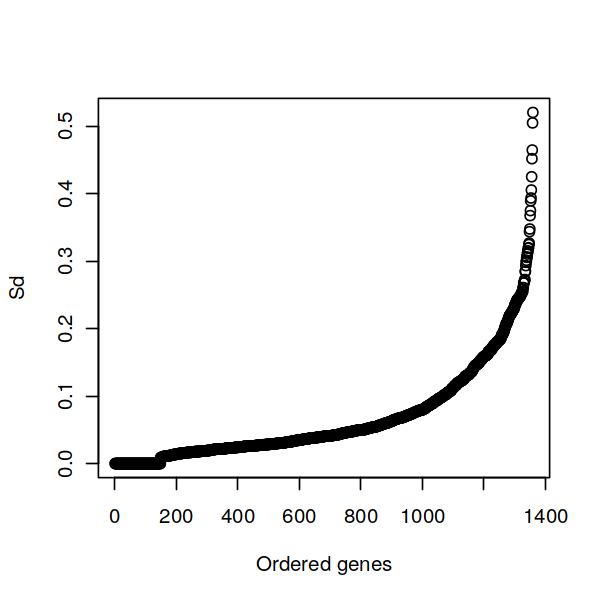

In [5]:
# 1. load data
o(5,5)
goi = alp1.hvg
mat = read.csv('./221112-FL-aLP1_5to1-PathExpr.csv', row.names = 1)
colnames(mat) <- paste("T",0:(ncol(mat)-1), sep='')
mat = mat[ intersect(goi,rownames(mat)), ]
eset <- new("ExpressionSet",exprs = as.matrix(mat))
eset <- filter.std(eset,min.std=0.04) # filter data
eset <- standardise(eset)

## param est

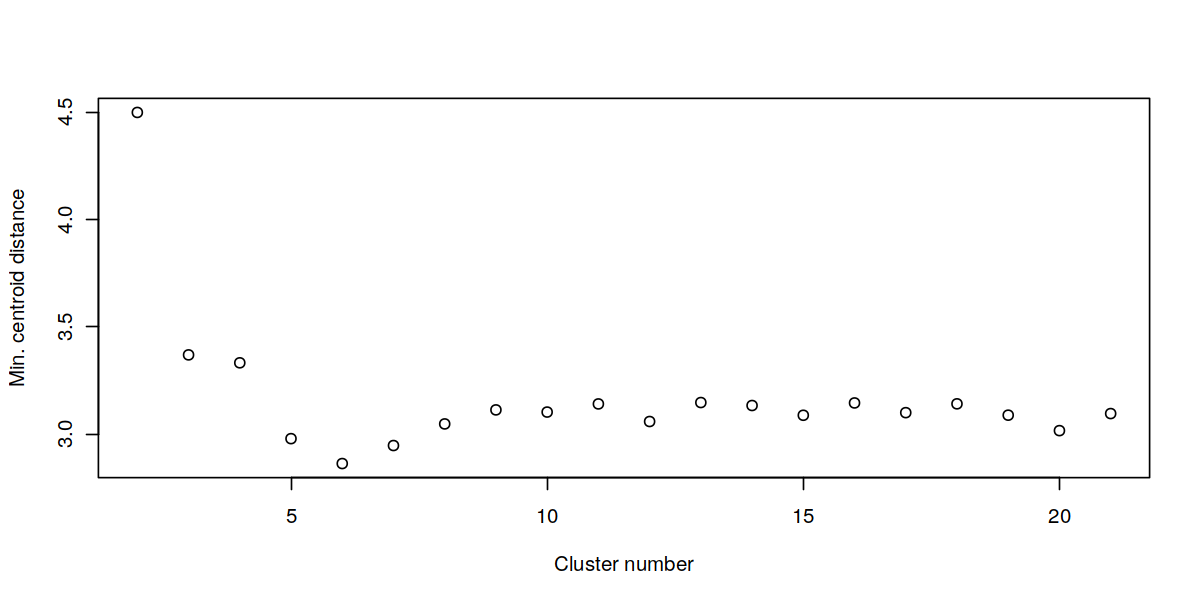

In [6]:
# 2. parameter estimation
m <- mestimate(eset)

# Find minimal distances among cluster centroids
o(10,5)
param.trial <-Dmin(eset, m=m, crange=seq(2,21,1), repeats=5, visu=T)

## do clustering

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:widgetTools’:

    funs


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


Warning message:
“Ignoring unknown aesthetics: order”


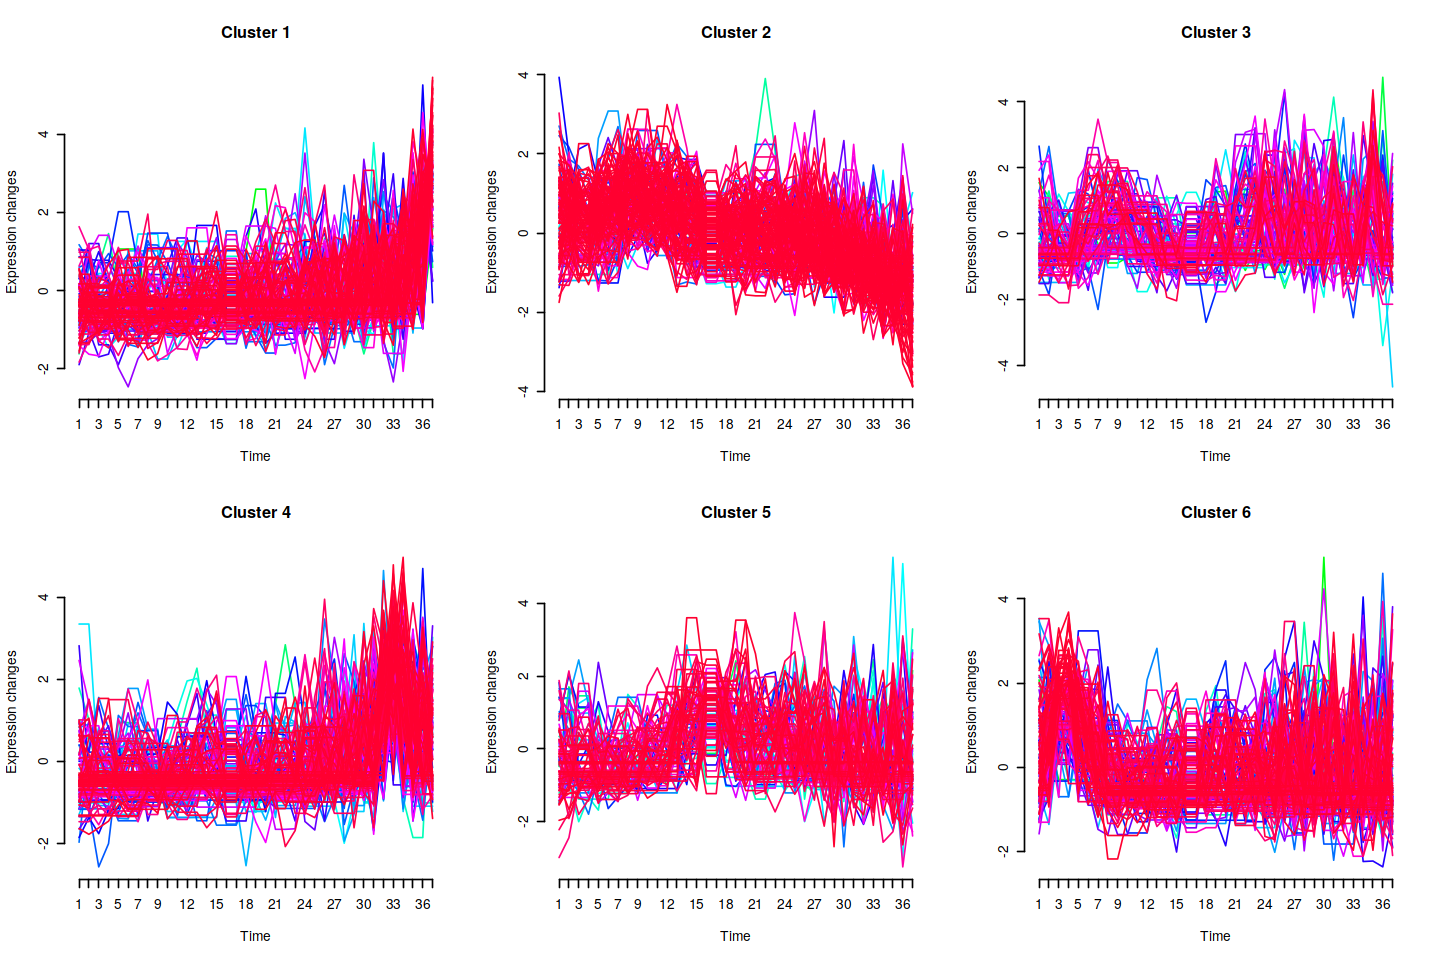

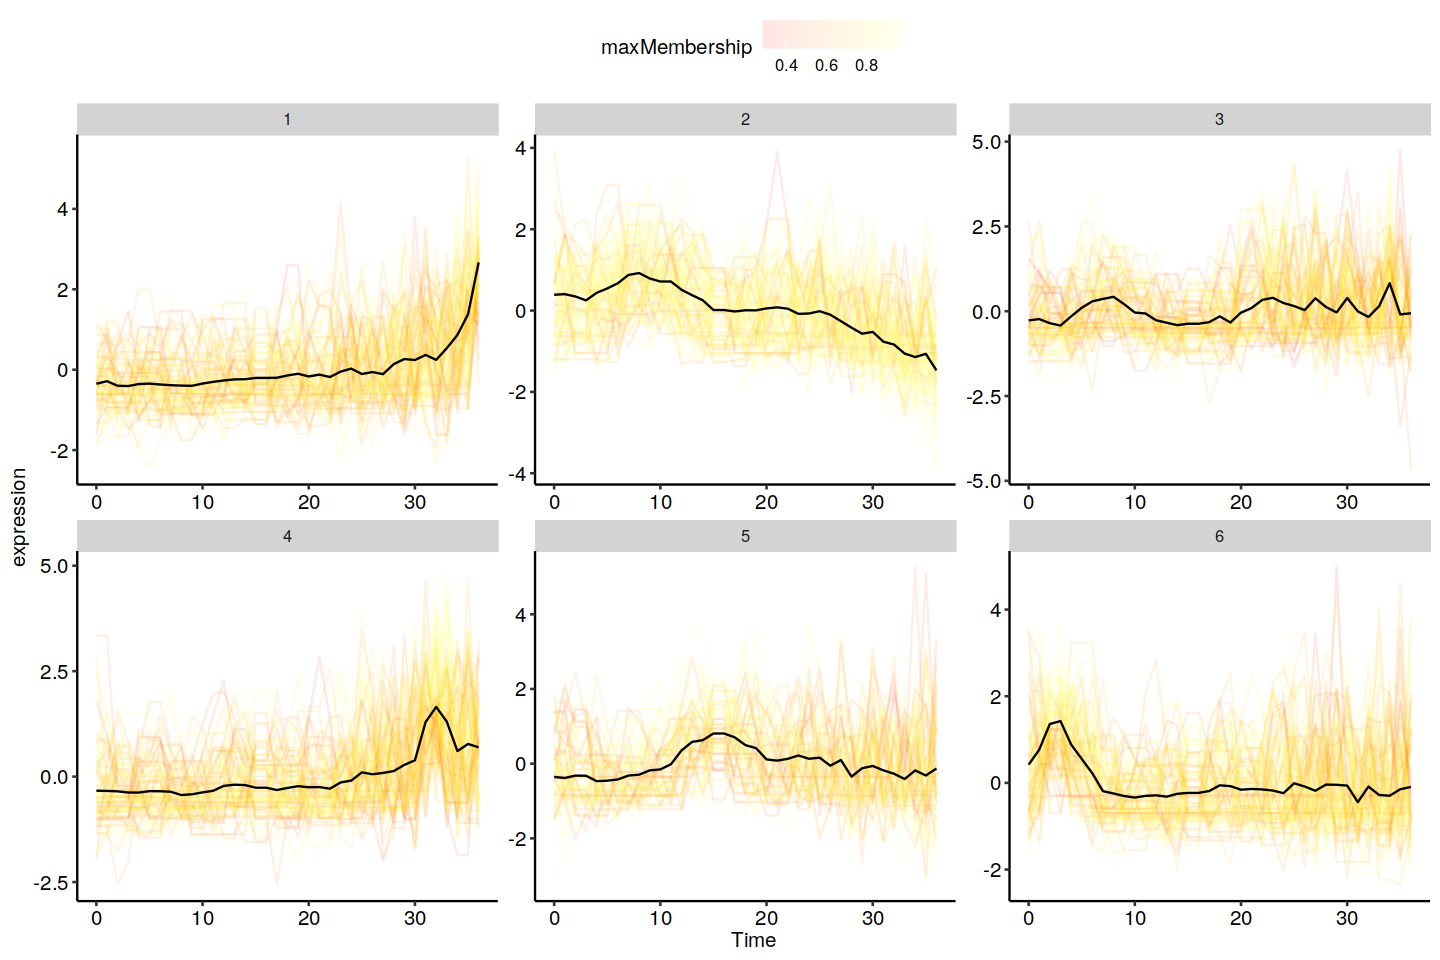

In [7]:
# 3. do clustering and show
c <- 6 # number of clusters
cl <- mfuzz(eset, c = c, m = m) # do clustering

o(3*4,4*2)
mfuzz.plot( eset,cl,mfrow=c(2,3), new.window= FALSE)


o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=3)

In [8]:
# 4. extract cluster information
# find number of genes in each cluster
cl$size

# extract genes within a certain cluster
cluster_gene <- as.data.frame(cl$cluster)
colnames(cluster_gene)<-'GeneCluster'
cluster_gene <- cluster_gene %>% mutate(gene = rownames(.))

# Find gene-cluster memberships
membership   <- cl$membership
colnames(membership) <-paste('BelongToGC',colnames(membership), sep='')
membership <- membership %>% as.data.frame %>% mutate(gene= rownames(.))

[1] 126 138  89 119  88 121

In [9]:
# 5. explain clusters

get_cluster_genes<- function(membership, cluster, cutoff){
    df = membership[, cluster,drop=F]
    colnames(df) <- 'affinity'
    df <- df %>% filter(affinity>cutoff) %>% arrange(desc(affinity))
    rownames(df)
}


path.enrichment.analysis<- function(pathid) {
    path.gene <- get_cluster_genes(membership, pathid, cutoff = 0.6)
    gene.df    <- bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
    enrich.res <- enrichGO(gene= gene.df$ENSEMBL,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
    enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
    enrich.tree <- tryCatch({
        treeplot(enrich.res)
    }, warning = function(warning_condition) {
        print('treeplot failed')
        1}, 
       error = function(error_condition) {
        print('treeplot failed')
        2
    }, finally={-1})
    
    result <- list()
    result[['path.gene']]  <-path.gene
    result[['enrich.res']] <-enrich.res
    result[['enrich.tree']]<-enrich.tree
    return(result)
}

In [10]:
res1 <- path.enrichment.analysis(1)
res2 <- path.enrichment.analysis(2)
res3 <- path.enrichment.analysis(3)
res4 <- path.enrichment.analysis(4)
res5 <- path.enrichment.analysis(5)
res6 <- path.enrichment.analysis(6)


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“0.97% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“3.94% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“2.94% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.26% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.41% of input gene

# Analysis result

Warning message:
“Ignoring unknown aesthetics: order”


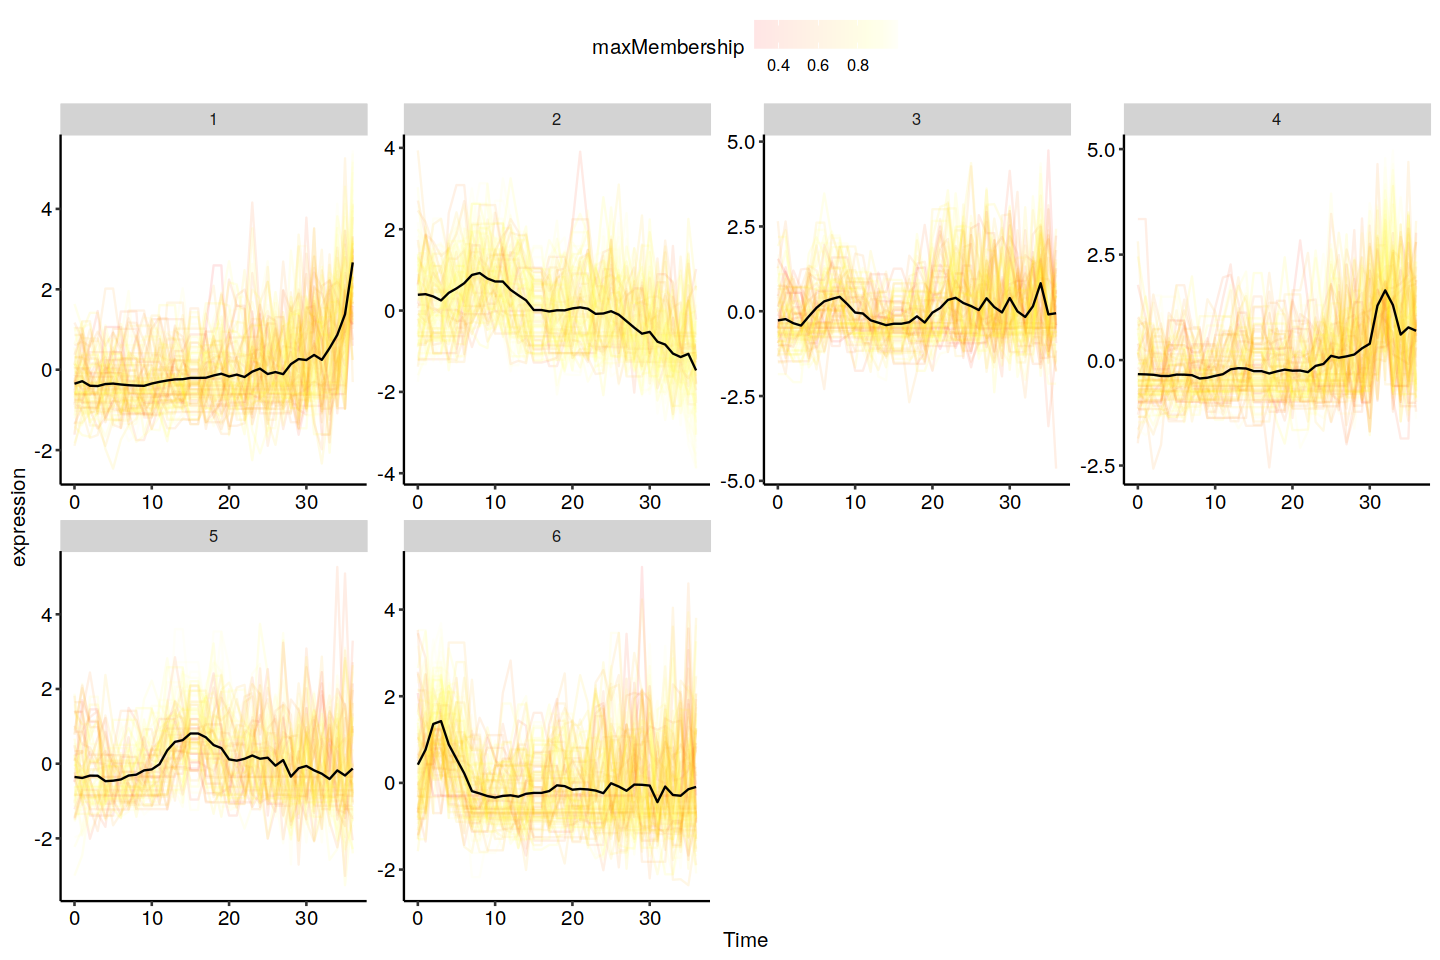

In [11]:
o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=4)

## C1

[1] "Genes:"
Pirb Ddit4l Cd74 Cd7 Shisa5 Calm4 Ptms Tyrobp Zfp36l1 Wfdc18 Sema3d Ctsa 6330403K07Rik Napsa Wfdc17 Necab2 Slc46a3 Vsir Clec4a2 Ly86 Inpp5f Klrd1 Ppp1r15a Psap Ifi35 Cd9 Snai3 H2-T23 H2-DMb2 Cd200r1 Evl Eya2 Ifi203 Fam49a Nucb2 4930481A15Rik Tspan13 Mndal Tapbp Gsn Id2 Basp1 Yipf2 Serp1 Hsd11b1 Il18 Pld4 Ctss Tcf4 Jund Sirpa Rnase6 Ppp3ca Gm2a Phf11c Mxd4 Fam117b Lgals3 Unc93b1 Rrad Anxa6 Cd52 Tmsb15b1 Hoxa9 Cyba Alox5ap Selenop Acadm Tnfaip8l2 Nfam1 Fzr1 Socs3 Trbc2 Arid3a Tpd52 Tnni2 Paip2b Nmrk1 Plp2 Abhd6 Ccl3 Ighv1-77 Stk17b Cst3 Ypel3 Fth1 Evi5 Ppfia4 Ighm Cyth4 Grina Cln8 Lgals9 Junb Cd69 Mfap2 Capsl Zcchc18 Pltp A630001G21Rik Gm5086 Btg1 4931406C07RikNULL
[1] "TFs:"
Cd7 Zfp36l1 Snai3 Eya2 Id2 Tcf4 Jund Mxd4 Hoxa9 Arid3a JunbNULL


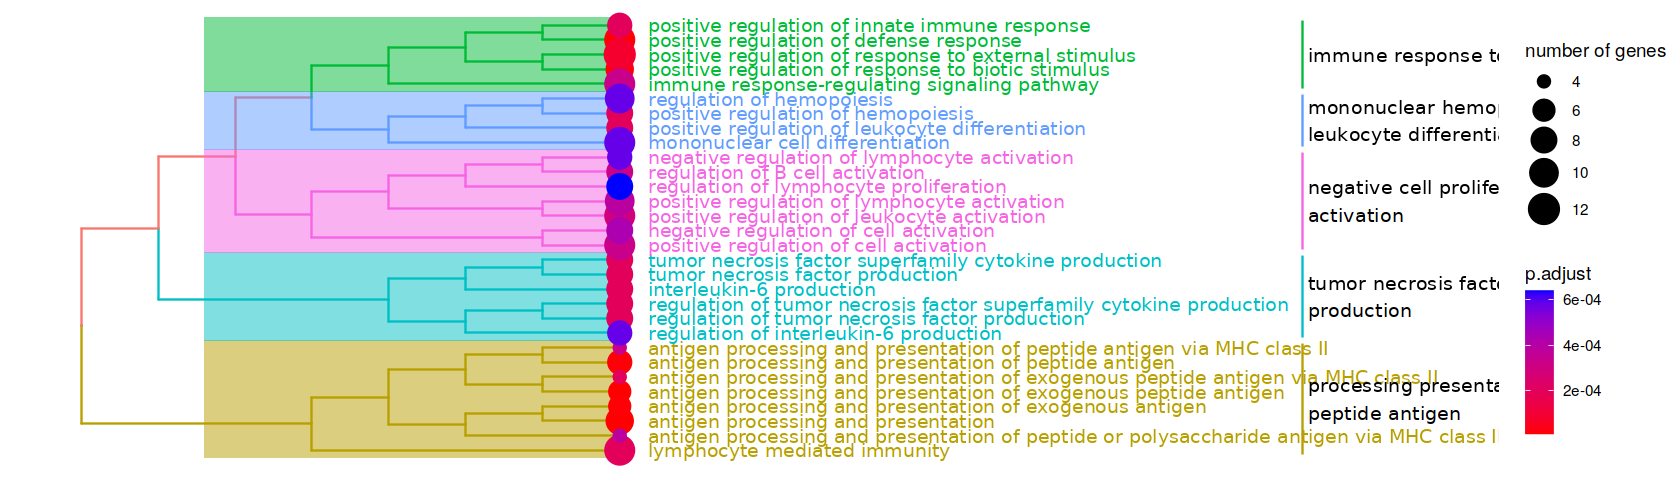

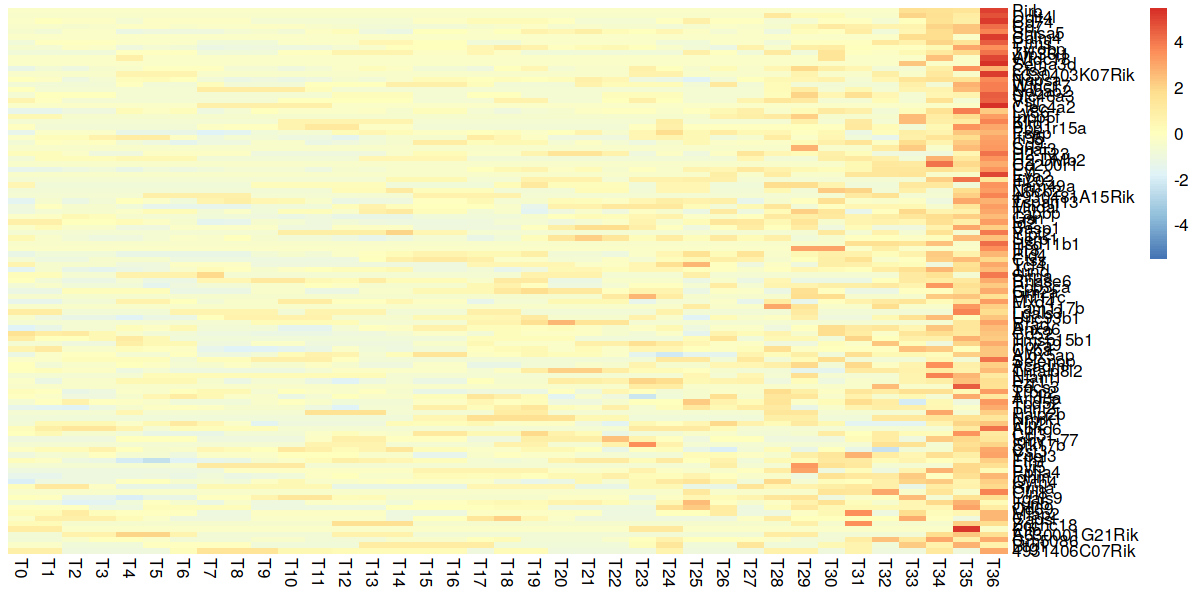

In [12]:
print('Genes:')
print(cat(res1$path.gene))#
print('TFs:')
print(cat(intersect(res1$path.gene, tf)))#

o(14,4)
plot(res1$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res1$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C2

[1] "Genes:"
Cycs Aurkb Pclaf Srm Gfi1b Cdca8 Syce2 H2afx Anp32b Rrm2 Spc24 Asf1b Mpo Pcna Ncl Mcm5 Tubb5 Cdk1 Tmem121 Fabp5 Tuba1b Ldha Mif Dek Cebpb Ranbp1 Smc2 Shcbp1 Myc Mcm7 Hist1h1b Srebf2 Sell Dlk1 Calr Nasp Cdv3 Dut Pbk Fam189b Cks2 Kifc1 Ccna2 Hmga2 Calm2 Lig1 Tyms Nucks1 Oaf Gmnn Usp37 Clspn Ap3s1 Ran Ccne2 Perp Ly6d Gm47283 Stmn1 Kpna2 Reep4 Pim1 Kif22 Hells Kif2c Sqle Comt Ccnf Top2a Fbxo5 Tubb4b Smc4 Ccnb1 Cd24a Tmpo Hmgb3 Hmgb2 Csf2ra Cnn3 Rpa2 Cdca7 Nde1 Mgst2 Tuba8 Hes6 Anxa2 Zbtb16 Hbb-bt Selplg Tmed3 Hist1h4i Klf2 Tuba4a Prc1 Auts2 Atad2 Fyb P2rx4 Crip1 Tk1 Zbtb20 Tspo Gpr132 H2-Ab1 Tpx2 Mcm3 Acp5 Prtn3 Uhrf1 Dhfr Cd63 Igfbp4 Hbb-bs Mis18bp1 Platr17 Lat Mta3 Jpt1 Spaca9 E2f1 Plk1 Cpa3 Myl10 Rexo2 Rbpms Racgap1 H2-K1NULL
[1] "TFs:"
Gfi1b Cebpb Myc Srebf2 Hmga2 Kpna2 Hmgb3 Hmgb2 Hes6 Zbtb16 Klf2 Zbtb20 Mcm3 Mis18bp1 Mta3 E2f1NULL


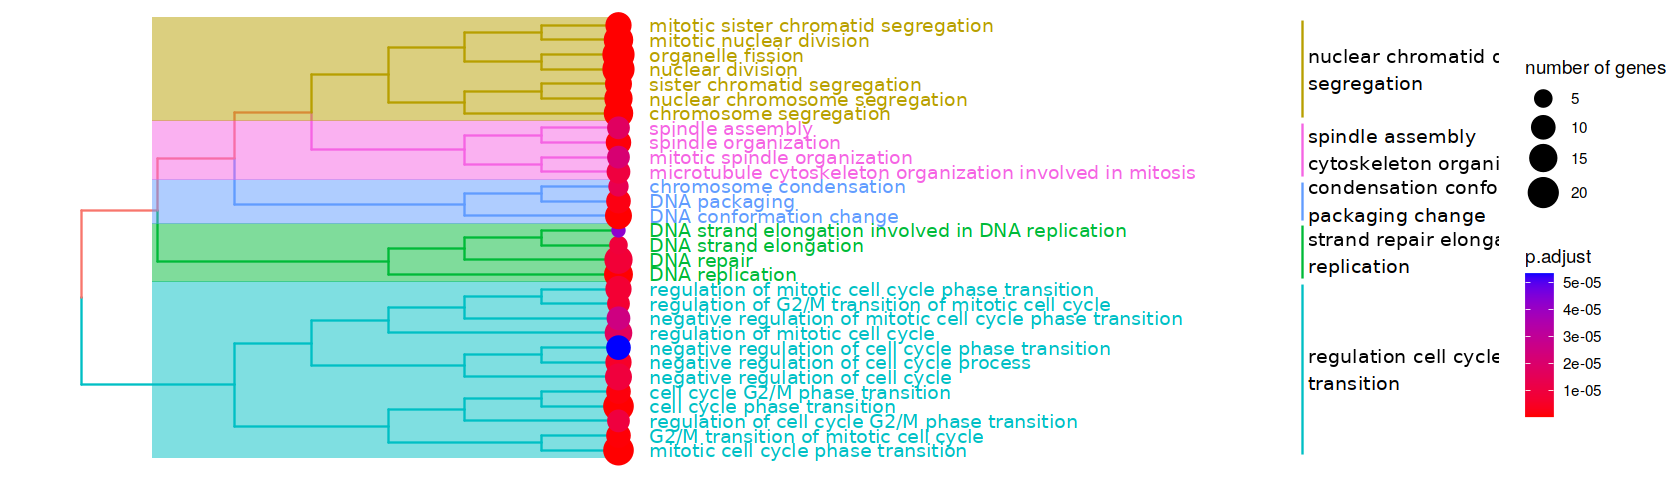

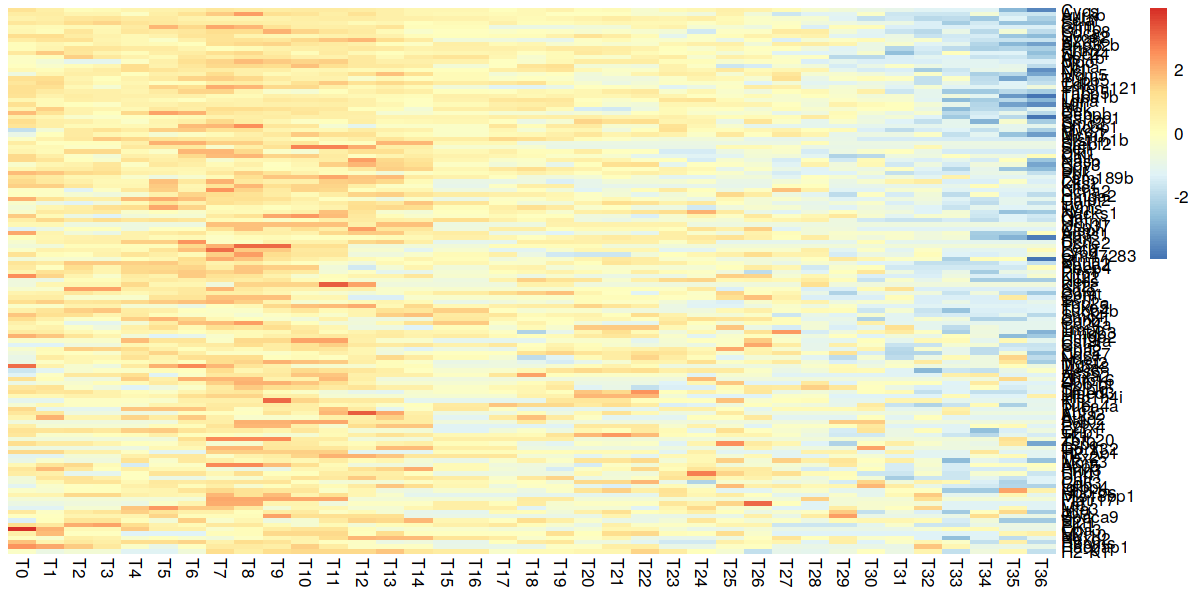

In [13]:
print('Genes:')
print(cat(res2$path.gene))#
print('TFs:')
print(cat(intersect(res2$path.gene, tf)))#

o(14,4)
plot(res2$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res2$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C3

[1] "Genes:"
Nfkbia Cd82 Terf2ip Nfkbid Apoc1 S100a4 Tulp4 Pkig Ifitm3 Tcp11l2 Cdkn2d Pld3 Mindy2 Cd6 Mcm2 Nfkbie Sp140 Acot1 Sstr2 Eif2ak2 Il12a Pygm Cox6a2 Eps15 Mycn Unc13d Ehbp1l1 Itga4 Lpcat2 Sox4 Rgcc Dok2 Grhpr Wdcp Dnajb14 Endov Pkib Dnajc7 Tsc22d3 Tmem176b Clic4 Gfod2 Zfp36 Xlr3b Ebf1 Dennd1c Nr4a1 Fscn1 Isg20 Gstt2 Ifi27 Kctd14 Morc1 Camk2a Hba-a2 Sept11 Car2 Xrcc6 1500011B03Rik Carhsp1 Ccl5 Lyz2 Cdyl2 Gna15 H2afv Grn Dusp2 MdkNULL
[1] "TFs:"
Nfkbia Tulp4 Sp140 Eif2ak2 Mycn Sox4 Tsc22d3 Zfp36 Ebf1 Nr4a1 Xrcc6 Carhsp1NULL


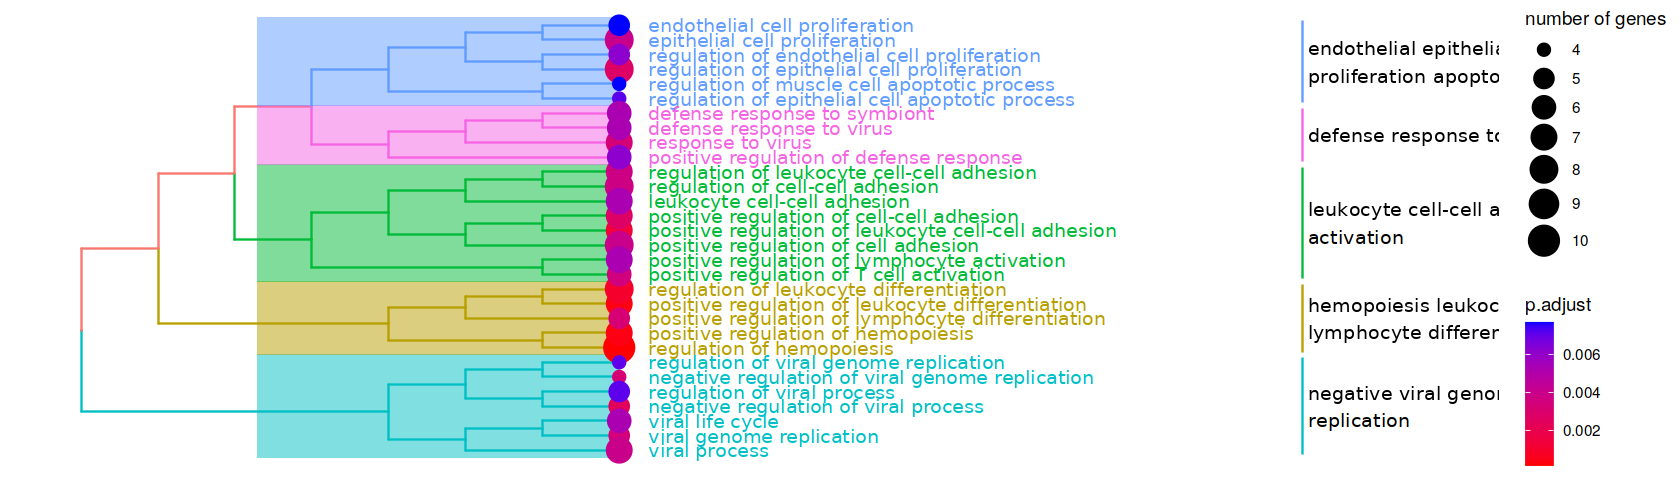

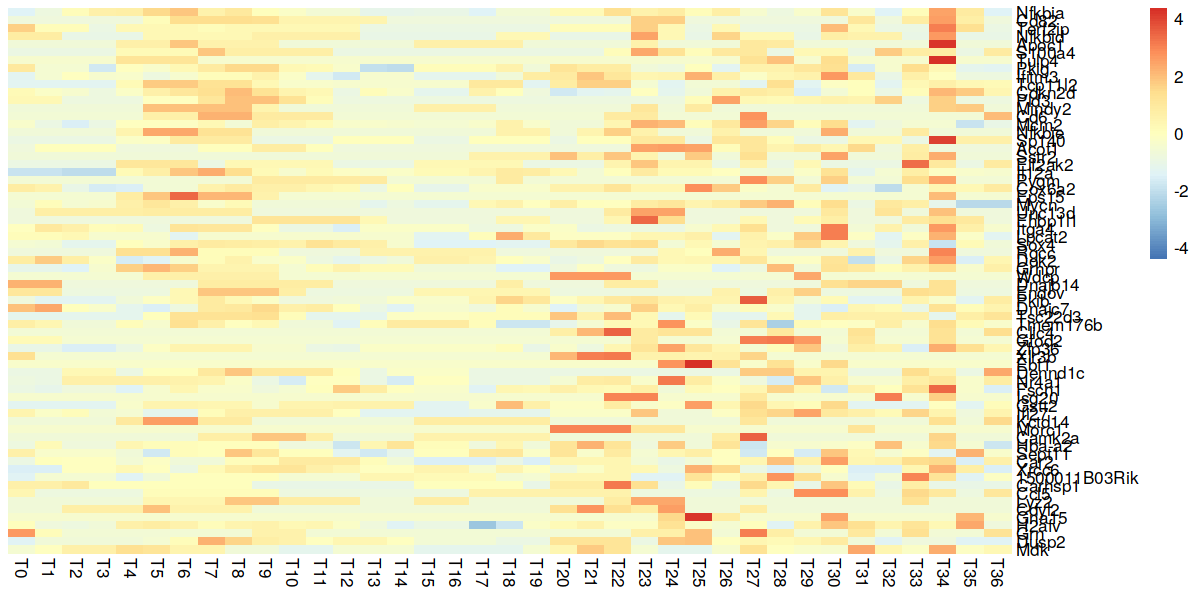

In [14]:
print('Genes:')
print(cat(res3$path.gene))#
print('TFs:')
print(cat(intersect(res3$path.gene, tf)))#

o(14,4)
plot(res3$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res3$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C4

[1] "Genes:"
Foxf1 Gm19331 Ctnnd2 Cavin2 Pacsin1 Marcks Hist1h2bc Maf Ccnb2 Ifnar1 Hic1 Isg15 Rhoh Hist3h2ba 2610035D17Rik Tsc22d1 Clec2i Rab19 Arid5b 9230105E05Rik Eva1b Rasgrp4 Ogt Sp100 Rgs2 Tcta Hoxa7 Setd4 Jchain Cdkn1c Ier3 Lpar6 Cd81 Rgs10 Ccl4 Capg Prr13 Notch1 Agpat3 Tmem51 Fcgr3 Pkp3 Itm2c Lax1 Cfp Ccr7 Btg2 Vim Lmo4 Tnfrsf13c Lgmn Gpcpd1 Tmeff2 Lockd Pbxip1 Irf7 Blcap Ier5 Lppos Cenpa Jup Hlx Pdcd1 Ccr9 Scpep1 Smox Sh2d3c Kdm5b Hvcn1 Arl6ip1 Paqr5 Ctso Lck Tbxa2r Sema4b Ebi3 Cd72 Tpm4 Trp53i11 Herpud1 Ddit4 Paqr7 S100a11 Grifin Plaur 9130015A21Rik Lmo2 Smim5 Plin3 H2-Oa Ifi27l2a Hck Anxa5 Pdk2NULL
[1] "TFs:"
Foxf1 Maf Hic1 Tsc22d1 Arid5b Sp100 Hoxa7 Notch1 Btg2 Lmo4 Irf7 Cenpa Hlx Lmo2NULL


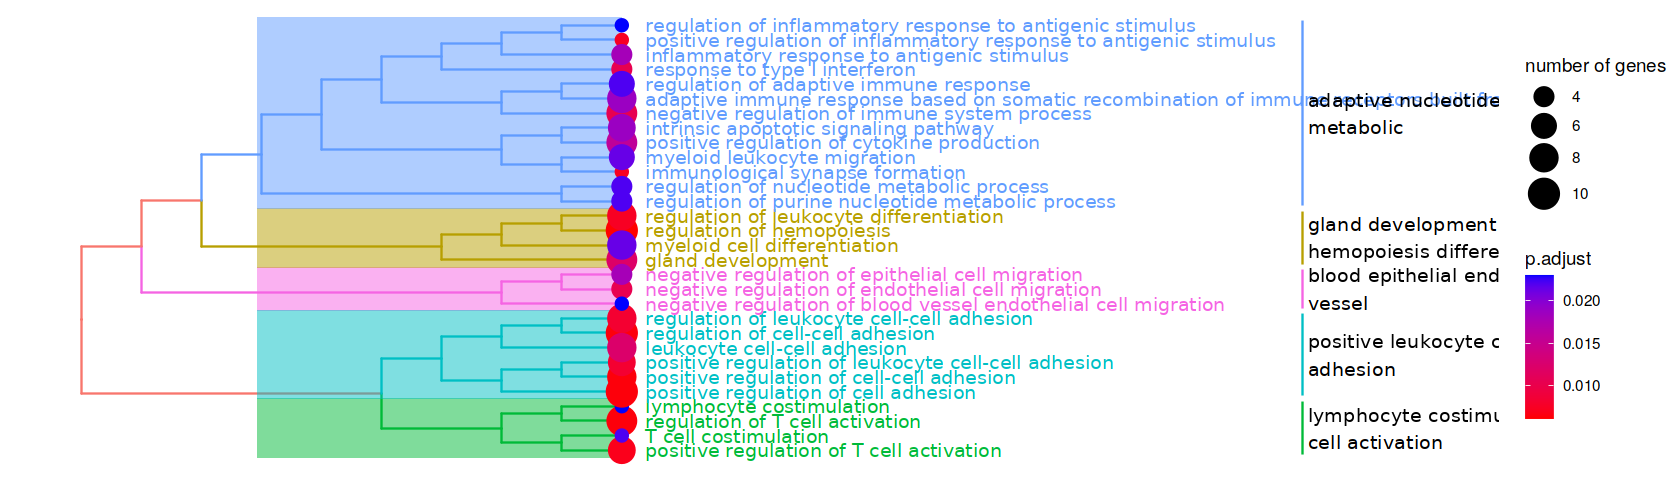

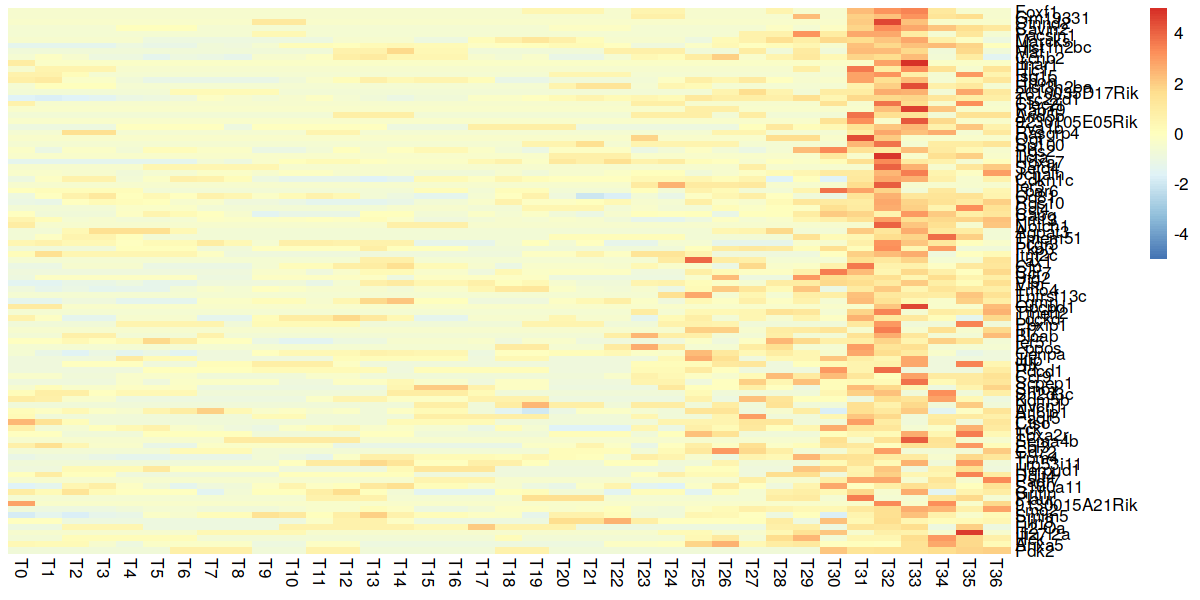

In [15]:
print('Genes:')
print(cat(res4$path.gene))#
print('TFs:')
print(cat(intersect(res4$path.gene, tf)))#

o(14,4)
plot(res4$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res4$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C5

[1] "Genes:"
Emb S100a6 Gadd45b Ncapd2 Slc8b1 Slco4a1 Ccnd2 Cnn2 Ung Ctr9 Capn3 Zfp467 Tmem158 Ccnd1 Cd28 Smad7 Abhd17b Epsti1 Egfl7 Mid1ip1 Samsn1 Tfrc Manf B930036N10Rik Dnajb9 Incenp Cks1b Hmgn3 Tuba1c Cd96 Glipr1 Plek Ift57 Serpinb1a Cd34 Prdx5 Gpr171 Nfil3 Tmem108 Trim55 Nek6 Paip1 H2afz Slbp Birc5 Gem Fgr Runx2os1 Hmgn2 Calcoco1 Blvrb Ccne1 Mt1 Sdf2l1 Jun Tcf19 Gnb4 Rgs1 Gimap9 Spi1 Pola2 Vps37a Socs1 Lmnb1 Gimap4 Ckap2l Usp18 Ifitm1NULL
[1] "TFs:"
Ctr9 Zfp467 Ccnd1 Smad7 Hmgn3 Plek Nfil3 Jun Tcf19 Spi1NULL


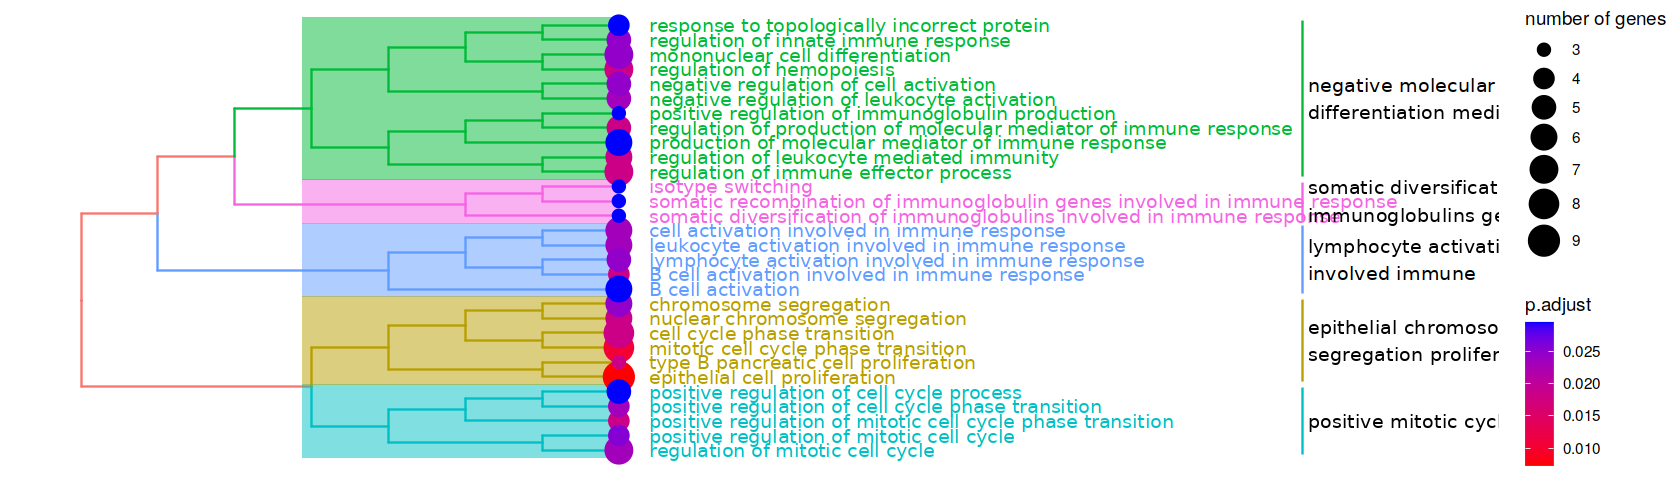

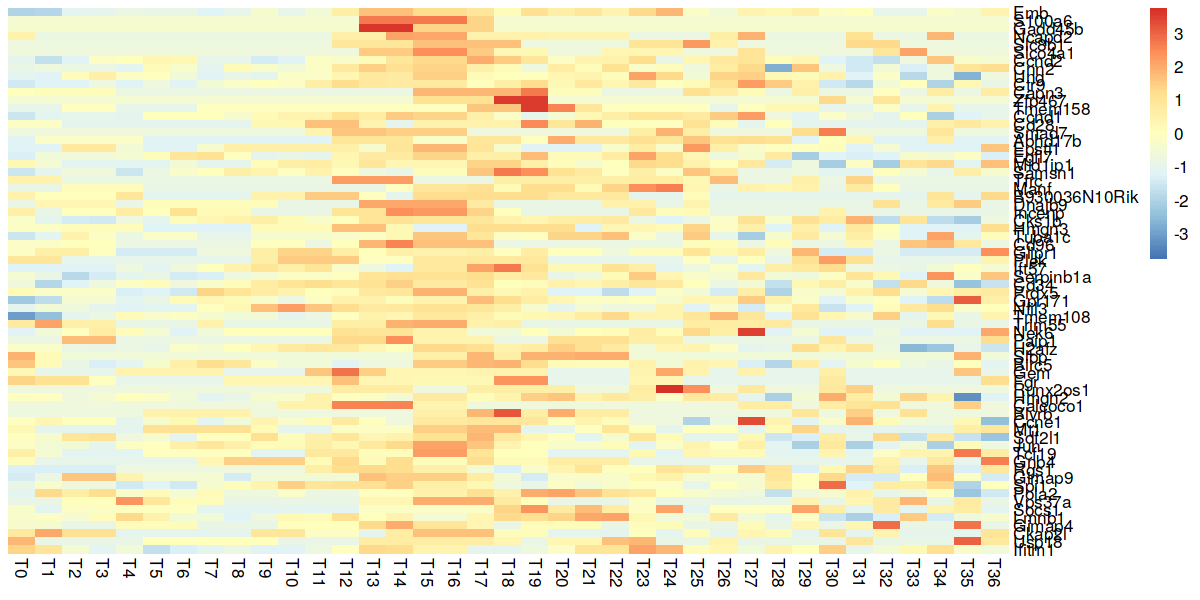

In [16]:
print('Genes:')
print(cat(res5$path.gene))#
print('TFs:')
print(cat(intersect(res5$path.gene, tf)))#

o(14,4)
plot(res5$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res5$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C6

[1] "Genes:"
Gm4208 Hp Sapcd2 Dennd5b Hes1 2610528A11Rik Thy1 Ncf4 Tcrg-C1 Ube2s Slc43a2 Ablim1 Pglyrp1 Ms4a4b Sgo1 Hmmr Bst2 Ldhb 1110008P14Rik Naga Tox Sat1 Noa1 Pimreg Tpm2 Fxyd7 Trbc1 Rpgrip1 Kif20b Zfp992 Nkg7 2310001H17Rik Cd3g Cdca3 Gzma Asah1 Kif20a Bcl2 Fcer1g Dlgap5 Khk Gm26917 Lgals3bp Agl Dtl Nudt18 Lta Mki67 Galnt12 H19 Il6ra Ly6e Tnni1 Ube2c Lgals1 Slfn5 Spc25 Gyg Fgd2 Hist1h1c Aurka Msmo1 Sla2 Trim12a Tacc3 Mcpt8 Fdps Klf13 Tox2 N4bp2l1 Ifitm2 Pycard Bfsp2 Gm15518 Nfkb1 Dbt Ctsc Xlr4b H2-M3 Cldnd1 Gstm5 H2-D1 H2-DMb1 Dlgap4 Ttf1 Rassf4 Tmem50b Izumo4 P2ry14 Pdlim2 Hsp90b1 Smpdl3a Tipin Bub3 Fbxo6 Cdkn3 Plxnc1 Gm49169 Hk2 Irf8 Gimap5 BambiNULL
[1] "TFs:"
Hes1 Tox Zfp992 Sla2 Klf13 Tox2 Nfkb1 Ttf1 Bub3 Irf8NULL


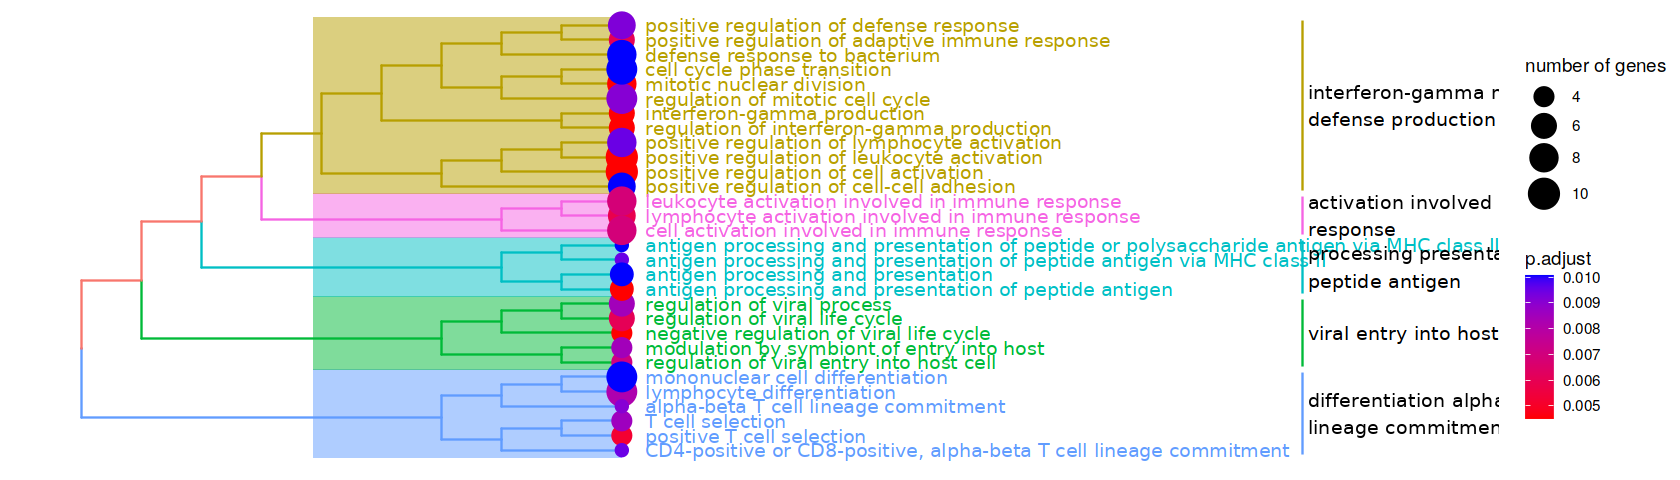

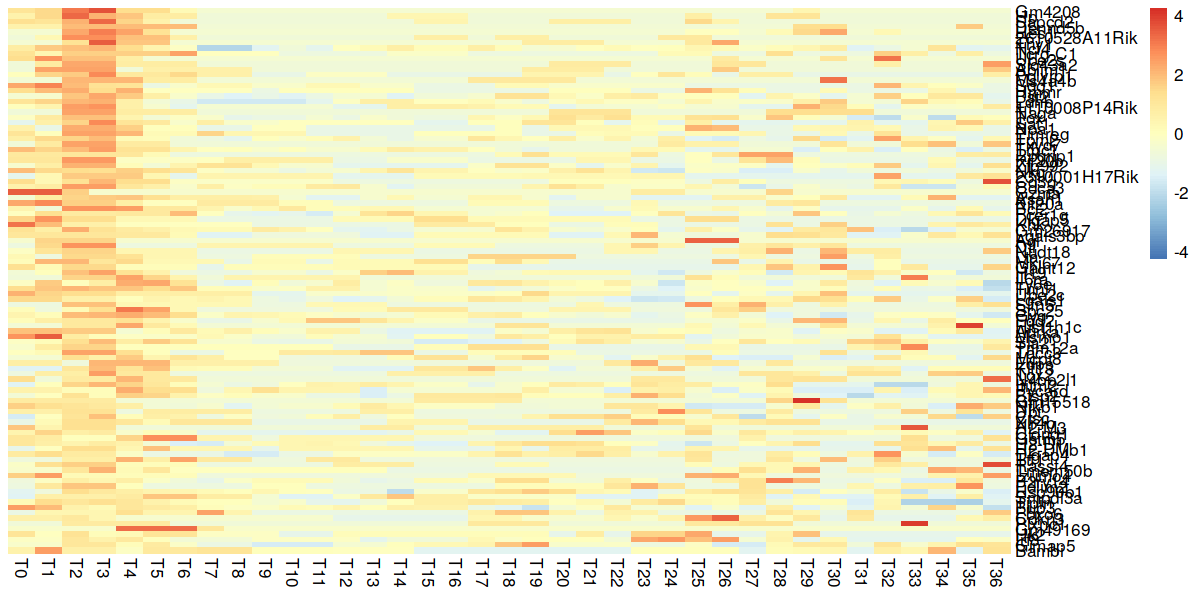

In [17]:
print('Genes:')
print(cat(res6$path.gene))#
print('TFs:')
print(cat(intersect(res6$path.gene, tf)))#

o(14,4)
plot(res6$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res6$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)

